In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm

sns.set()

limit = 100

In [2]:
def strip(x):
    return x.replace('\t','')

country_populations = pd.read_csv('world_pop.csv',
                                  sep=';',header=None,index_col=0,names=['population'],
                                 thousands=',',converters={0 : strip})


In [3]:
dick = pd.read_pickle('country_data.pkl')

us_state_dict = pd.read_pickle('us_state_dict.pkl')
ny = us_state_dict['New York']
ny.index = pd.DatetimeIndex(ny.index)
dick['New York'] = ny

ny.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 2020-03-14 to 2020-07-29
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   confirmed    138 non-null    float64
 1   deceased     138 non-null    float64
 2   inc          138 non-null    float64
 3   dead_inc     138 non-null    float64
 4   factor       138 non-null    float64
 5   dead_factor  137 non-null    float64
 6   density      138 non-null    float64
 7   gdp          138 non-null    int64  
 8   pct_dead     138 non-null    float64
 9   conf_per_M   138 non-null    float64
 10  dead_per_M   138 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 12.9 KB


In [4]:
def process_country(country_name):
    df = dick[country_name]
    
    df = df[df['confirmed'] > limit]
    
    resample_period = ['W-MON','W-TUE','W-WED','W-THU','W-FRI','W-SAT','W-SUN']
    
    today = pd.datetime.today().weekday()

    yesterday = lambda i : resample_period[i % 7 -1] if i != 0 else resample_period[6]
    print (today)
    print (yesterday(today))
    
    #### MAKE SURE to adjust the param of resample so that all data points for the last week are included
    weekly = df[['inc','dead_inc']].resample(yesterday(today)).sum()
    weekly[['inc_per_M','dead_inc_per_M']] = weekly[['inc','dead_inc']] / (
        country_populations.loc[country_name,'population'] / 1e6)
    ####
    
    weekly['factor'] = weekly['inc'] / weekly['inc'].shift()
    weekly['dead_factor'] = weekly['dead_inc'] / weekly['dead_inc'].shift()
    
    print ('+++++++ {} +++++++'.format(country_name))
    print (weekly)
    
    return weekly
    

In [5]:
def plot(weekly,country_name):
    
    plt.figure(figsize=(18,12))
    
    plt.plot(weekly.index,weekly['inc'],'x--',color='orange',
            label=r'new confirmed')
    plt.plot(weekly.index,weekly['dead_inc'],'x--',color='crimson',
            label = 'new dead')
    
   
    
    plt.plot(weekly.index,weekly['factor'],'o-',color='orange',
            label=r'weekly growth factor confirmed [ last weekly growth factor: {:.2f} ]'.format(weekly['factor'][-1]))
    
    plt.plot(weekly.index,weekly['dead_factor'],'o-',color='crimson',
             label=r'weekly growth factor dead [ last weekly growth factor: {:.2f} ]'.format(weekly['dead_factor'][-1]))
    
    plt.title('Corona - weekly sum of new CONFIRMED and DEAD for {} [confirmed > {}]'.format(str.upper(country_name),limit))
    
    plt.plot(weekly.index, [1] * len(weekly.index),color='lime',ls = 'dashed',label='factor 1.00')
    
    y_max = weekly['inc'].max() * 10
    y_min = 0.1
    
    plt.ylim([y_min,y_max])
    plt.yscale('log')
    plt.ylabel('weekly total')  
    plt.xticks(rotation=90)
    plt.legend(loc='upper left')
    
    plt.savefig('corona_weekly_sums_{}.jpg'.format(country_name),format='jpg')


3
W-WED


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


+++++++ Sweden +++++++
               inc  dead_inc   inc_per_M  dead_inc_per_M    factor  \
2020-03-11   406.0       1.0   40.200945        0.099017       NaN   
2020-03-18   779.0       9.0   77.134326        0.891154  1.918719   
2020-03-25  1247.0      52.0  123.474332        5.148890  1.600770   
2020-04-01  2421.0     177.0  239.720415       17.526028  1.941460   
2020-04-08  3472.0     448.0  343.787394       44.359664  1.434118   
2020-04-15  3508.0     516.0  347.352010       51.092827  1.010369   
2020-04-22  4077.0     734.0  403.692744       72.678556  1.162201   
2020-04-29  4298.0     525.0  425.575525       51.983981  1.054207   
2020-05-06  3616.0     479.0  358.045858       47.429194  0.841322   
2020-05-13  3991.0     519.0  395.177273       51.389878  1.103706   
2020-05-20  3614.0     371.0  357.847824       36.735347  0.905537   
2020-05-27  3565.0     389.0  352.995985       38.517655  0.986442   
2020-06-03  5715.0     322.0  565.882765       31.883508  1.603086 

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


3
W-WED
+++++++ Spain +++++++
                inc  dead_inc    inc_per_M  dead_inc_per_M     factor  \
2020-03-04    138.0       2.0     2.951570        0.042776        NaN   
2020-03-11   2055.0      52.0    43.952727        1.112186  14.891304   
2020-03-18  11633.0     569.0   248.808796       12.169879   5.660827   
2020-03-25  35605.0    3024.0   761.526448       64.677882   3.060689   
2020-04-01  54603.0    5740.0  1167.859251      122.768201   1.533577   
2020-04-08  44102.0    5405.0   943.261884      115.603158   0.807685   
2020-04-15  29424.0    3916.0   629.326055       83.756146   0.667181   
2020-04-22  30745.0    3009.0   657.579852       64.357059   1.044895   
2020-04-29   4528.0    2558.0    96.845717       54.710986   0.147276   
2020-05-06   7408.0    1582.0   158.443700       33.836114   1.636042   
2020-05-13   8366.0    1247.0   178.933584       26.671071   1.129320   
2020-05-20   3864.0     784.0    82.643960       16.768340   0.461869   
2020-05-27   3704.0  

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


3
W-WED
+++++++ Italy +++++++
                inc  dead_inc   inc_per_M  dead_inc_per_M    factor  \
2020-02-26    391.0      10.0    6.466890        0.165394       NaN   
2020-03-04   2636.0      95.0   43.597757        1.571239  6.741688   
2020-03-11   9373.0     720.0  155.023436       11.908340  3.555766   
2020-03-18  23251.0    2151.0  384.556695       35.576167  2.480636   
2020-03-25  38673.0    4525.0  639.626729       74.840611  1.663283   
2020-04-01  36188.0    5652.0  598.526416       93.480471  0.935743   
2020-04-08  28848.0    4514.0  477.127502       74.658678  0.797170   
2020-04-15  25733.0    3976.0  425.607391       65.760502  0.892020   
2020-04-22  22172.0    3440.0  366.710724       56.895404  0.861617   
2020-04-29  16264.0    2597.0  268.996176       42.952722  0.733538   
2020-05-06  10866.0    2002.0  179.716703       33.111802  0.668101   
2020-05-13   7647.0    1422.0  126.476498       23.518972  0.703755   
2020-05-20   5260.0    1224.0   86.997042      

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


3
W-WED
+++++++ US +++++++
                 inc  dead_inc    inc_per_M  dead_inc_per_M     factor  \
2020-03-04      31.0       4.0     0.093655        0.012084        NaN   
2020-03-11    1005.0      22.0     3.036229        0.066465  32.419355   
2020-03-18    7808.0     155.0    23.588935        0.468274   7.769154   
2020-03-25   57138.0    1145.0   172.620974        3.459187   7.317879   
2020-04-01  148150.0    5513.0   447.579497       16.655456   2.592845   
2020-04-08  215481.0   11717.0   650.994786       35.398508   1.454479   
2020-04-15  208288.0   14766.0   629.263842       44.609915   0.966619   
2020-04-22  199448.0   14983.0   602.557108       45.265498   0.957559   
2020-04-29  205616.0   13648.0   621.191399       41.232298   1.030925   
2020-05-06  190489.0   12891.0   575.490859       38.945307   0.926431   
2020-05-13  162583.0   10383.0   491.183377       31.368329   0.853503   
2020-05-20  163047.0    9299.0   492.585179       28.093431   1.002854   
2020-05-27 

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


3
W-WED
+++++++ Germany +++++++
                inc  dead_inc   inc_per_M  dead_inc_per_M    factor  \
2020-03-04    183.0       0.0    2.184189        0.000000       NaN   
2020-03-11   1646.0       3.0   19.645769        0.035806  8.994536   
2020-03-18  10419.0      25.0  124.355572        0.298387  6.329891   
2020-03-25  24996.0     178.0  298.338791        2.124512  2.399079   
2020-04-01  40549.0     714.0  483.971022        8.521919  1.622220   
2020-04-08  35424.0    1429.0  422.801782       17.055774  0.873610   
2020-04-15  21457.0    1455.0  256.099194       17.366096  0.605719   
2020-04-22  15895.0    1475.0  189.714158       17.604805  0.740784   
2020-04-29  10891.0    1188.0  129.989109       14.179328  0.685184   
2020-05-06   6623.0     808.0   79.048560        9.643853  0.608117   
2020-05-13   5936.0     586.0   70.848898        6.994180  0.896271   
2020-05-20   4375.0     283.0   52.217643        3.377736  0.737028   
2020-05-27   3051.0     284.0   36.415093    

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


3
W-WED
+++++++ Netherlands +++++++
               inc  dead_inc   inc_per_M  dead_inc_per_M    factor  \
2020-03-11   421.0       5.0   24.569778        0.291803       NaN   
2020-03-18  1555.0      53.0   90.750605        3.093107  3.693587   
2020-03-25  4380.0     299.0  255.619067       17.449795  2.816720   
2020-04-01  7258.0     818.0  423.580637       47.738903  1.657078   
2020-04-08  6986.0    1080.0  407.706576       63.029359  0.962524   
2020-04-15  7634.0     890.0  445.524192       51.940861  1.092757   
2020-04-22  6716.0     923.0  391.949237       53.866758  0.879748   
2020-04-29  3966.0     659.0  231.457813       38.459581  0.590530   
2020-05-06  2520.0     494.0  147.068505       28.830096  0.635401   
2020-05-13  1892.0     360.0  110.418099       21.009786  0.750794   
2020-05-20  1237.0     186.0   72.191960       10.855056  0.653805   
2020-05-27  1323.0     123.0   77.210965        7.178344  1.069523   
2020-06-03   969.0     106.0   56.551342        6.1862

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


3
W-WED
+++++++ Sweden +++++++
               inc  dead_inc   inc_per_M  dead_inc_per_M    factor  \
2020-03-11   406.0       1.0   40.200945        0.099017       NaN   
2020-03-18   779.0       9.0   77.134326        0.891154  1.918719   
2020-03-25  1247.0      52.0  123.474332        5.148890  1.600770   
2020-04-01  2421.0     177.0  239.720415       17.526028  1.941460   
2020-04-08  3472.0     448.0  343.787394       44.359664  1.434118   
2020-04-15  3508.0     516.0  347.352010       51.092827  1.010369   
2020-04-22  4077.0     734.0  403.692744       72.678556  1.162201   
2020-04-29  4298.0     525.0  425.575525       51.983981  1.054207   
2020-05-06  3616.0     479.0  358.045858       47.429194  0.841322   
2020-05-13  3991.0     519.0  395.177273       51.389878  1.103706   
2020-05-20  3614.0     371.0  357.847824       36.735347  0.905537   
2020-05-27  3565.0     389.0  352.995985       38.517655  0.986442   
2020-06-03  5715.0     322.0  565.882765       31.883508  1

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


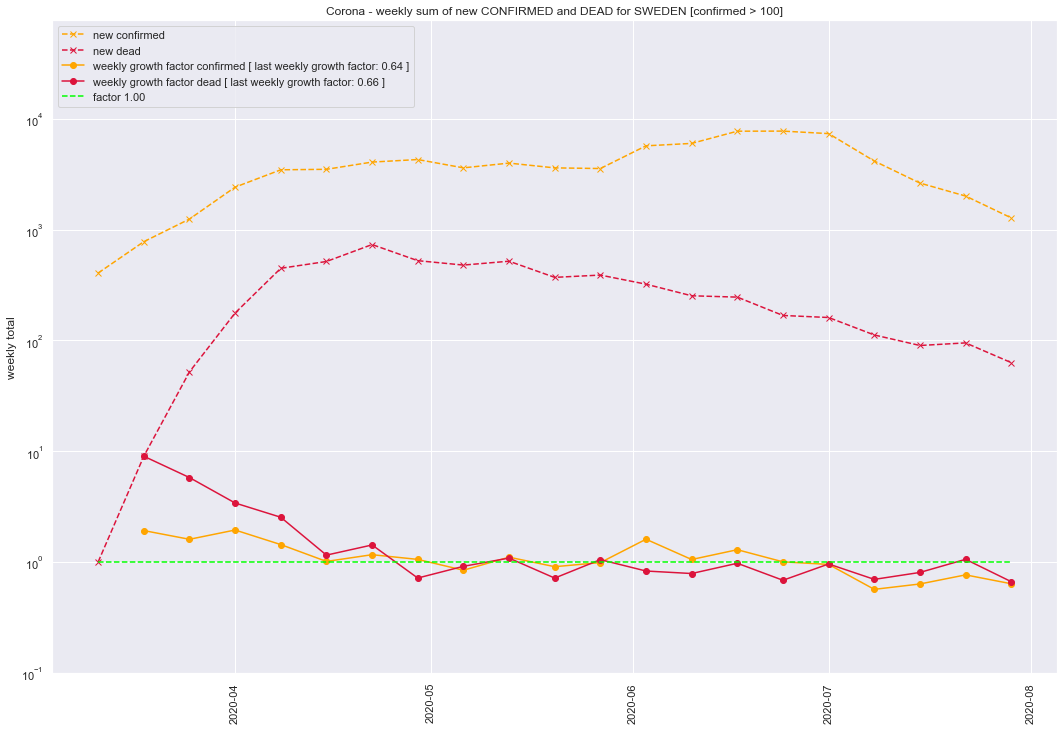

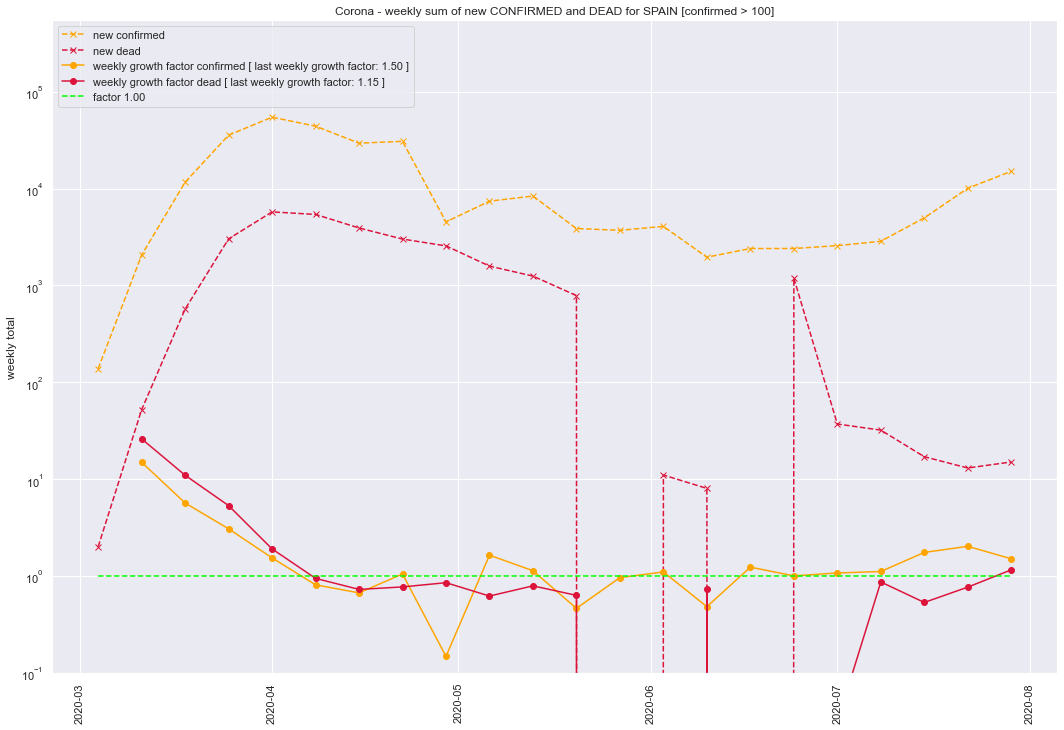

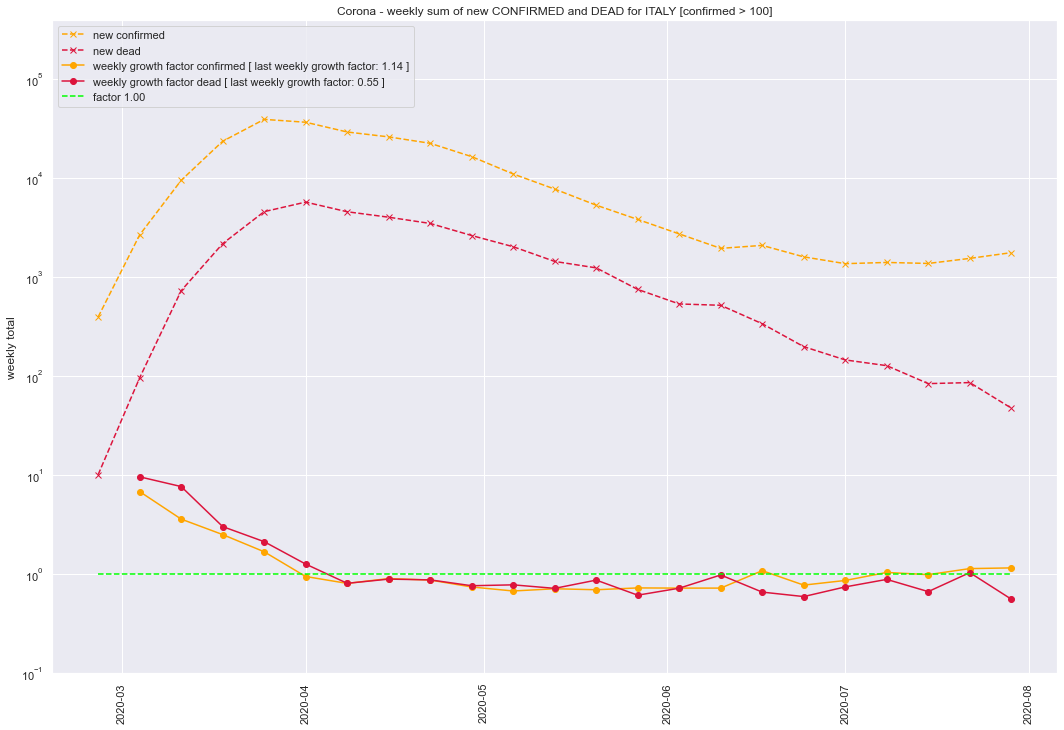

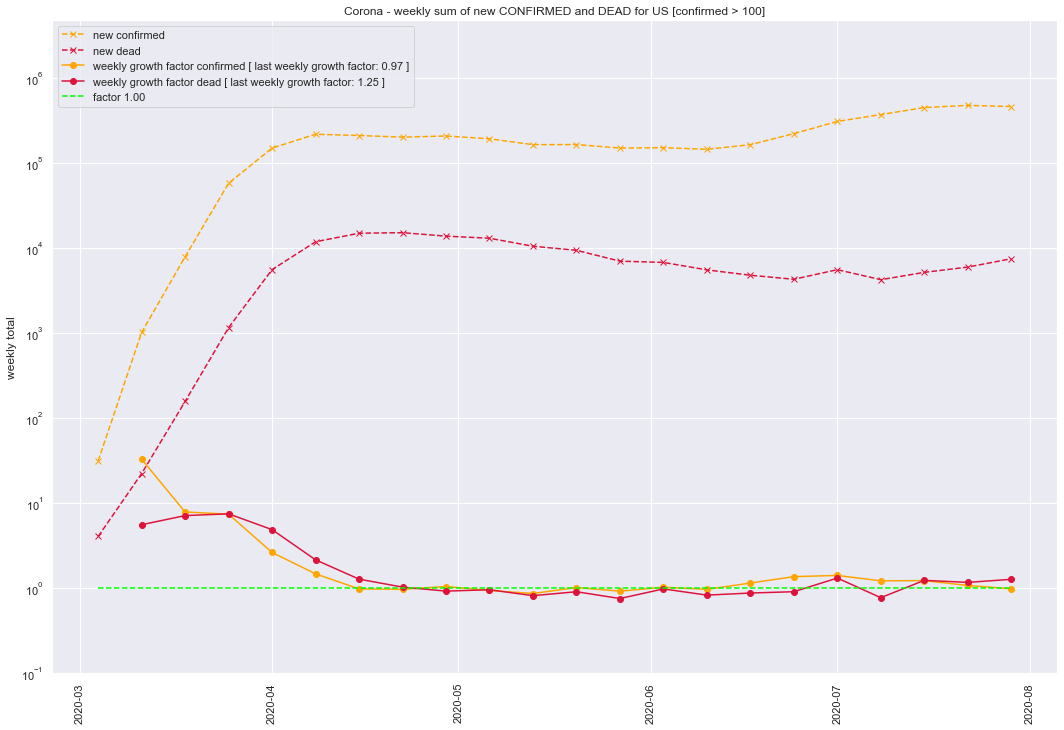

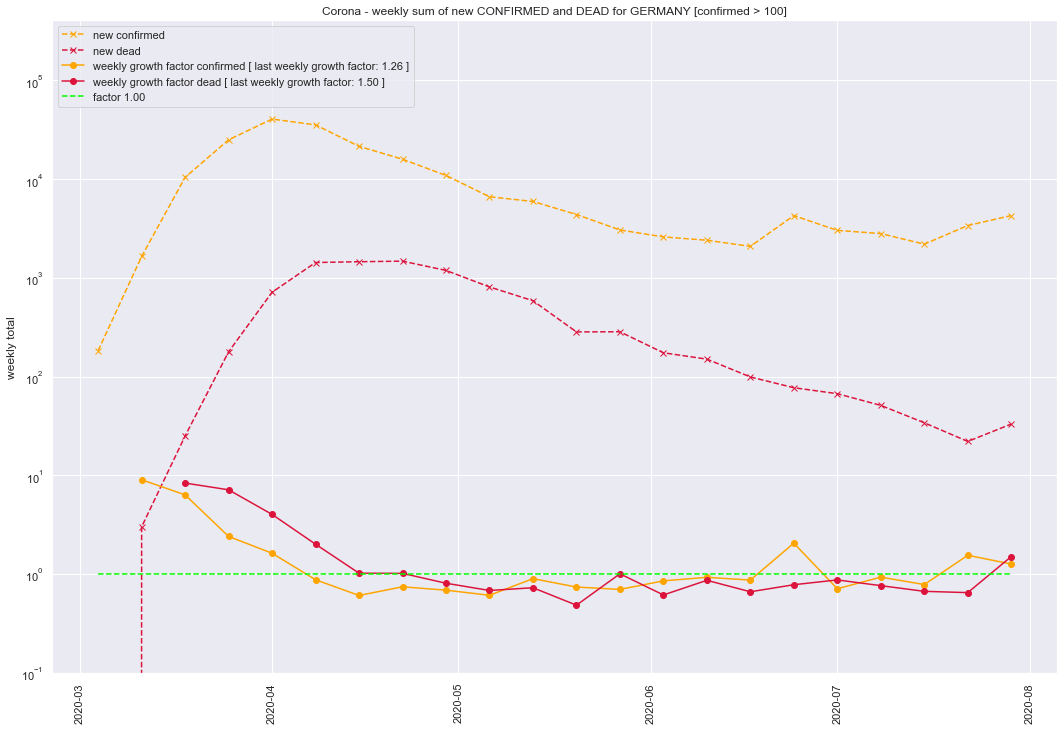

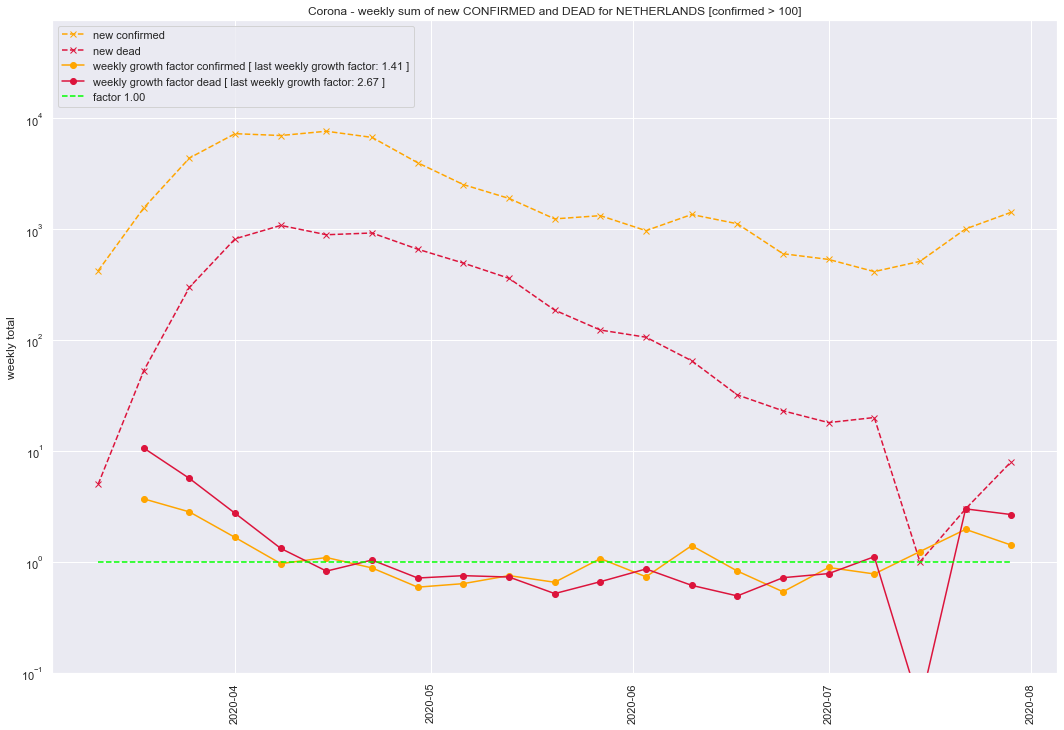

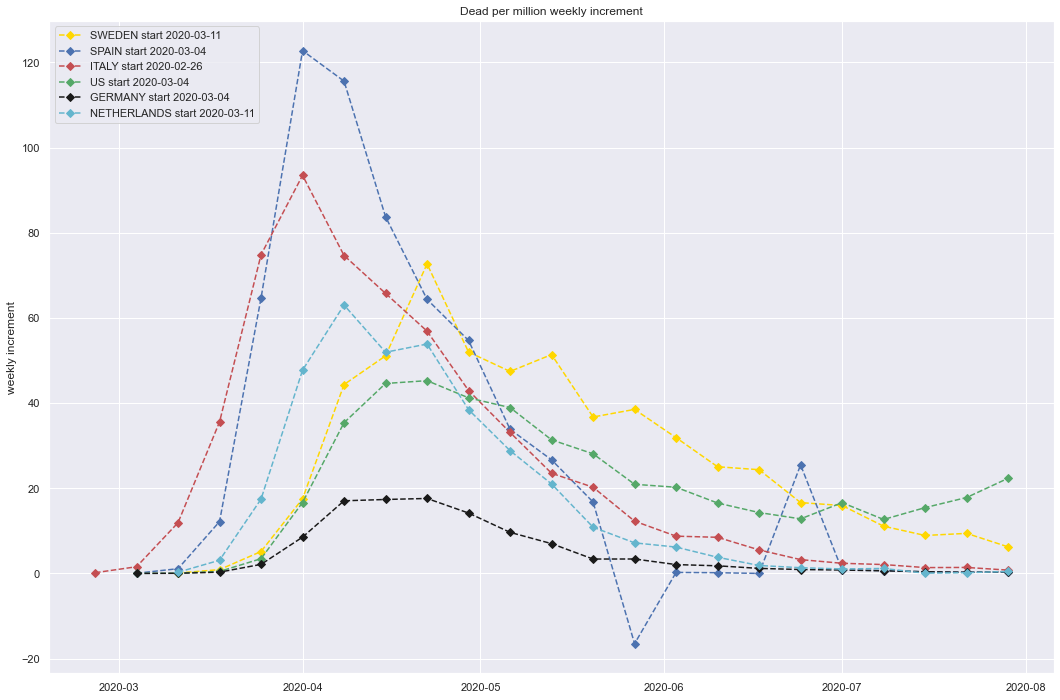

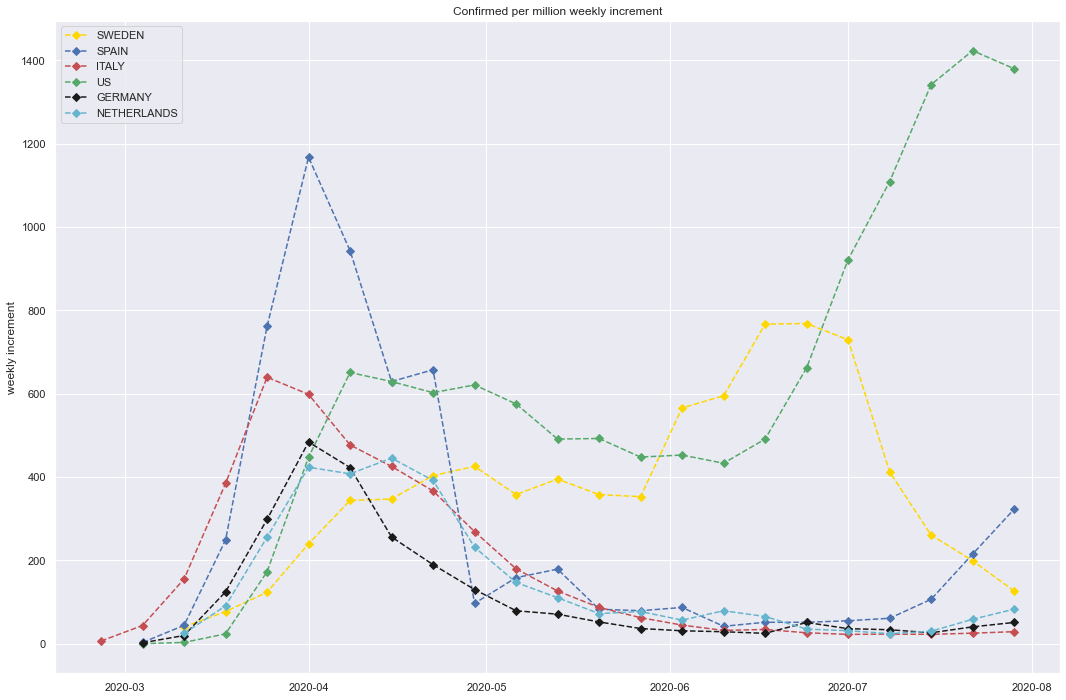

In [6]:
countries = ['Sweden','Spain','Italy','US','Germany','Netherlands']
colors = ['gold','b','r','g','k','c','lime']
#countries = ['Finland','Denmark','Norway','Austria','Belgium','France']
#countries = ['New York']

fignr = 1

for c in countries:
    weekly = process_country(c)
    print ('++++++++++++++++ {} ++++++++++++++'.format(str.upper(c)))
    print (c,weekly.tail(10))
    plot(weekly,c)
    fignr += 1
    


# plot all normalized on same plot

plt.figure(fignr + 1,figsize=(18,12))
plt.figure(fignr + 2,figsize=(18,12))

for i,c in enumerate(countries):
    plt.figure(fignr +1 )
    plt.title('Dead per million weekly increment')
    weekly = process_country(c)
    
    plt.plot(weekly.index,weekly['dead_inc_per_M'],'D--',
             color=colors[i],label=c.upper() + ' start ' + str(weekly.index[0].date()))
    
    #plt.yscale('log') # NOTICE that log scale makes the growth look much smaller...!!!
    
    plt.legend(loc='upper left')
    plt.ylabel('weekly increment')
    plt.figure(fignr + 2)
    plt.title('Confirmed per million weekly increment')
    plt.plot(weekly.index,weekly['inc_per_M'],'D--',color=colors[i],label=c.upper())
    plt.legend(loc='upper left')
    plt.ylabel('weekly increment')

plt.figure(fignr +1)
plt.savefig('weekly__dead_consolidated_sums_per_million.jpg')
plt.figure(fignr +2)
plt.savefig('weekly_conf_consolidated_sums_per_million.jpg')